#### We are going to be using the LeNet model for convolution.

#### The Preprocessing steps are identical to the MNIST classification Model through fully connected layers.

#### Importing Libraries and Data Preprocessing.

In [1]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn 
import torch.nn.functional as F 

In [2]:
transform = transforms.Compose([
                                transforms.Resize((28, 28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

training_loader = DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [3]:
def im_convert(ten):
    image =ten.clone().detach().numpy()
    image = image.transpose(1,2,0)# Original (color, width, height) new (width, height, color)
    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5,0.5, 0.5))
    image = image.clip(0, 1)
    return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


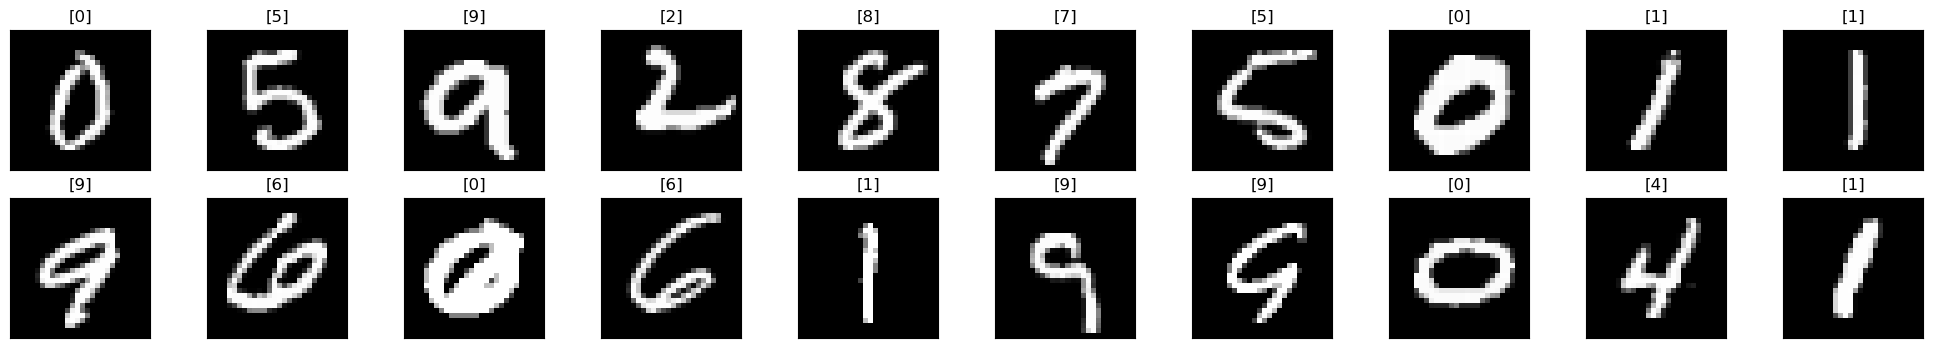

In [4]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]), cmap='gray')
    ax.set_title([(labels[idx].item())])


#### Model and Training.

In [5]:
class LeNet(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # Try kernel size 10
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(in_features=4*4*50, out_features=500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=500, out_features=10)

    def forward(self, x):
        # x = x.view(100, 28, 28)
        # x = x.view(28, 28, 100)
        # x = x.unsqueeze(0)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,1), 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,1), 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) # try softmax activation
        return x 

In [6]:
model = LeNet()
model 

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#### The training process is also identical.

In [8]:
# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Choose the appropriate GPU device
else:
    device = torch.device("cpu")     # Use CPU if GPU is not available

# Assuming you've defined and initialized model, criterion, and optimizer
model = model.to(device)  # Move the model to the GPU or CPU

epochs = 18
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []


for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    model.train()  # Set the model to training mode

    for inputs, labels in training_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU or CPU.
        # inputs = inputs.view(inputs.shape[0], -1)
        # print(inputs.shape)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)


        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('Epoch [{}/{}], Training Loss: {:.4f}, Acc: {:.4f}'
              .format(e + 1, epochs, epoch_loss, epoch_acc.item()))
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Acc: {:.4f}'
              .format(e + 1, epochs, val_epoch_loss, val_epoch_acc.item()))


# You can add a validation loop here to evaluate the model's performance on a validation dataset after each epoch


/home/areeb/anaconda3/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch [1/18], Training Loss: 0.5029, Acc: 87.7817
Epoch [1/18], Validation Loss: 0.1692, Validation Acc: 95.2700
Epoch [2/18], Training Loss: 0.1449, Acc: 95.7983
Epoch [2/18], Validation Loss: 0.1019, Validation Acc: 96.8100
Epoch [3/18], Training Loss: 0.1015, Acc: 97.0067
Epoch [3/18], Validation Loss: 0.0757, Validation Acc: 97.8100
Epoch [4/18], Training Loss: 0.0811, Acc: 97.6017
Epoch [4/18], Validation Loss: 0.0666, Validation Acc: 97.8700
Epoch [5/18], Training Loss: 0.0664, Acc: 98.0067
Epoch [5/18], Validation Loss: 0.0547, Validation Acc: 98.2700
Epoch [6/18], Training Loss: 0.0571, Acc: 98.3017
Epoch [6/18], Validation Loss: 0.0474, Validation Acc: 98.6100
Epoch [7/18], Training Loss: 0.0499, Acc: 98.5633
Epoch [7/18], Validation Loss: 0.0438, Validation Acc: 98.5600
Epoch [8/18], Training Loss: 0.0436, Acc: 98.6967
Epoch [8/18], Validation Loss: 0.0386, Validation Acc: 98.7400
Epoch [9/18], Training Loss: 0.0392, Acc: 98.8650
Epoch [9/18], Validation Loss: 0.0370, Validat

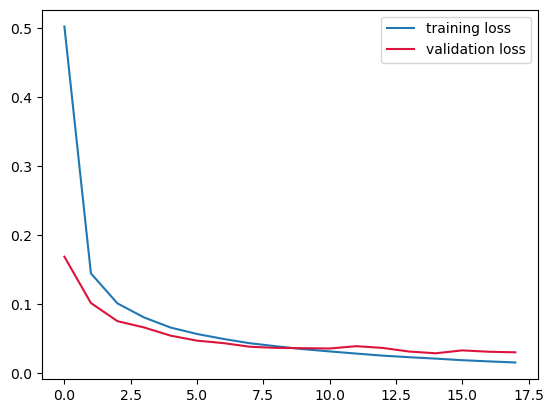

In [9]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label = "validation loss", c="crimson")
plt.legend()

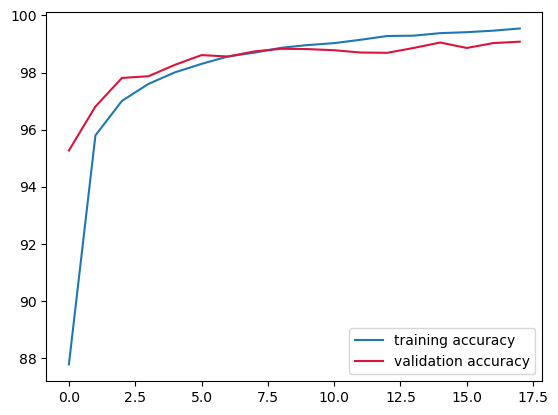

In [10]:
plt.plot([c.cpu().detach().numpy() for c in running_corrects_history], label='training accuracy')
plt.plot([c.cpu().detach().numpy() for c in val_running_corrects_history], label = "validation accuracy", c="crimson")
plt.legend()

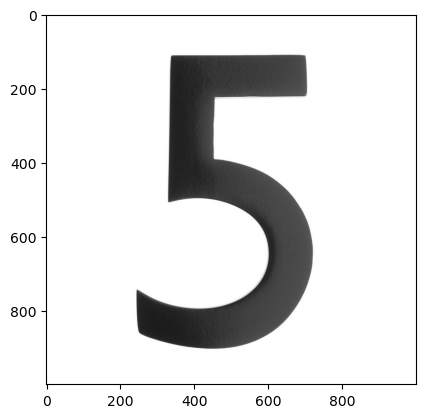

In [11]:
url_for_test_image = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
import requests
from PIL import Image, ImageOps
response = requests.get(url_for_test_image, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

(28, 28, 1)


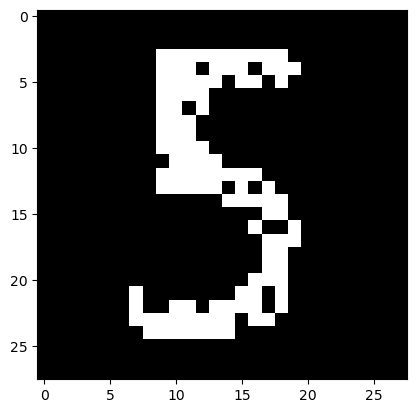

In [12]:
img = ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img), cmap='gray')

In [13]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


In [14]:
def image_tester(img_url):
    response = requests.get(img_url, stream=True)
    img = Image.open(response.raw)
    img = ImageOps.invert(img)
    img = img.convert('1')
    img = transform(img)
    plt.imshow(im_convert(img), cmap='gray')
    images = img.to(device)
    image = images[0].unsqueeze(0).unsqueeze(0)
    output = model(image)
    _, pred = torch.max(output, 1)
    print(pred.item())

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


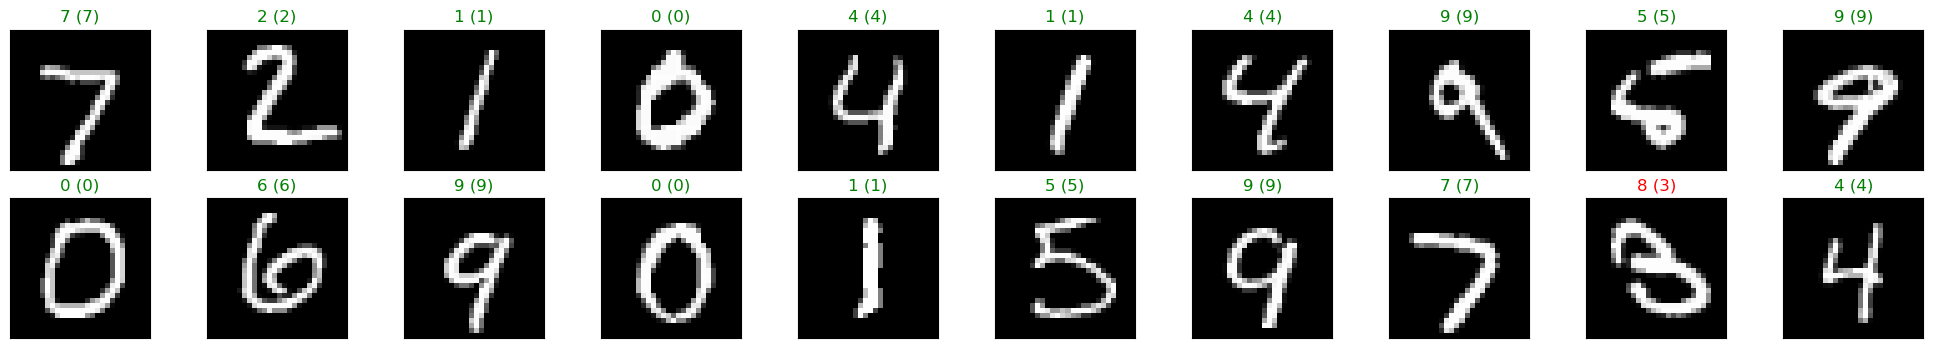

In [15]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images_ = images.to(device)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

(28, 28, 1)
6


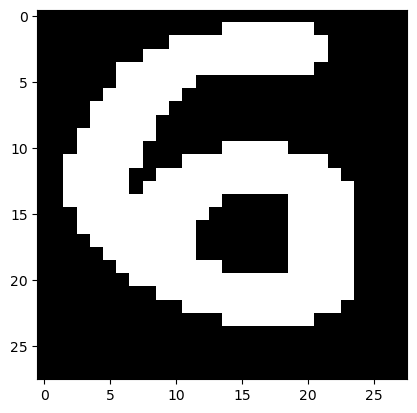

In [26]:
numeber_six = r"number six.jpg"
img = Image.open(numeber_six)
# img = ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img), cmap='gray')
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())